![image.png](https://i.imgur.com/a3uAqnb.png)
# CycleGAN Homework Task List

In this HW, you will implement a CycleGAN for selfie-to-anime and anime-to-selfie unpaired translations.  
You can read more about CycleGANs [here](https://machinelearningmastery.com/what-is-cyclegan/).

## 1. Dataset and Environment Setup
- [x] Download the provided dataset (code for this is provided below) .
- [x] Organize the dataset into appropriate training and test folders (if not already done).

## 2. Model Implementation
- [x] Implement the Generator and Discriminator models.
- [x] Define the loss functions:
  - Adversarial Loss
  - Cycle Consistency Loss
  - Identity Loss
- [x] Integrate all components into a full CycleGAN training pipeline.

## 4. Training the CycleGAN
- [x] Choose and configure training hyperparameters (e.g., learning rate, batch size, epochs).
- [x] Train your model using the training set.
- [x] Visualize training progress with sample outputs and loss plots.

## 5. Evaluation on Test Set
- [x] Generate and display 10 **selfie-to-anime** translations using test set images.
- [x] Generate and display 10 **anime-to-selfie** translations using test set images.

## 6. Evaluation on Internet Images
- [x] Select 3 random selfie images from the internet.
- [x] Select 3 random anime images from the internet.
- [x] Run both **selfie-to-anime** and **anime-to-selfie** translations on these images.
- [x] Display or save the outputs.



![CycleGANs](https://www.oreilly.com/api/v2/epubs/9781788836067/files/assets/d5036aa6-77cf-41c1-8828-11436977198e.png)

[Image Source](https://www.oreilly.com/library/view/hands-on-artificial-intelligence/9781788836067/c2e7d914-4e45-4528-8627-c590d19107ef.xhtml)

In [37]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arnaud58/selfie2anime")

print("Path to dataset files:", path)

Path to dataset files: /home/habiam0b/.cache/kagglehub/datasets/arnaud58/selfie2anime/versions/1


In [40]:

# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import itertools
from tqdm import tqdm
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [41]:
# Cell 2: Dataset Class
class SelfieAnimeDataset(Dataset):
    def __init__(self, root_selfie, root_anime, transform=None):
        self.root_selfie = root_selfie
        self.root_anime = root_anime
        self.transform = transform
        
        self.selfie_images = [f for f in os.listdir(root_selfie) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.anime_images = [f for f in os.listdir(root_anime) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        self.selfie_len = len(self.selfie_images)
        self.anime_len = len(self.anime_images)
        self.length = max(self.selfie_len, self.anime_len)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        selfie_img = Image.open(os.path.join(self.root_selfie, self.selfie_images[idx % self.selfie_len])).convert('RGB')
        anime_img = Image.open(os.path.join(self.root_anime, self.anime_images[idx % self.anime_len])).convert('RGB')
        
        if self.transform:
            selfie_img = self.transform(selfie_img)
            anime_img = self.transform(anime_img)
            
        return selfie_img, anime_img

In [42]:
# Cell 3: Generator Network
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )
    
    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, n_residual_blocks=6):
        super(Generator, self).__init__()
        
        # Initial convolution block
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2
        
        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]
        
        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2
        
        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]
        
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        return self.model(x)

In [43]:
# Cell 4: Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, input_nc=3):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(input_nc, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
    
    def forward(self, img):
        return self.model(img)

In [44]:
# Cell 5: Loss Functions
class CycleGANLoss:
    def __init__(self, lambda_cyc=10.0, lambda_id=5.0):
        self.lambda_cyc = lambda_cyc
        self.lambda_id = lambda_id
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
    
    def adversarial_loss(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.mse_loss(pred, target)
    
    def cycle_consistency_loss(self, real_images, cycled_images):
        return self.l1_loss(cycled_images, real_images)
    
    def identity_loss(self, real_images, same_images):
        return self.l1_loss(same_images, real_images)

In [47]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_path = path
train_selfie_path = os.path.join(dataset_path, "trainA")  # Selfie images
train_anime_path = os.path.join(dataset_path, "trainB")   # Anime images
test_selfie_path = os.path.join(dataset_path, "testA")    # Test selfie images
test_anime_path = os.path.join(dataset_path, "testB")     # Test anime images

In [52]:
# Create datasets
train_dataset = SelfieAnimeDataset(train_selfie_path, train_anime_path, transform)
test_dataset = SelfieAnimeDataset(test_selfie_path, test_anime_path, transform)

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 3400
Test samples: 100


In [53]:
# Cell 7: Model Initialization
# Initialize models
G_AB = Generator().to(device)  # Selfie to Anime
G_BA = Generator().to(device)  # Anime to Selfie
D_A = Discriminator().to(device)  # Discriminator for Selfie
D_B = Discriminator().to(device)  # Discriminator for Anime

# Initialize optimizers
lr = 0.0002
b1, b2 = 0.5, 0.999

optimizer_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

# Initialize loss
criterion = CycleGANLoss()

In [54]:
# Cell 8: Training Function
def train_epoch(epoch):
    G_AB.train()
    G_BA.train()
    D_A.train()
    D_B.train()
    
    running_g_loss = 0.0
    running_d_loss = 0.0
    
    for i, (real_A, real_B) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        
        # Train Generators
        optimizer_G.zero_grad()
        
        # Identity loss
        loss_id_A = criterion.identity_loss(real_A, G_BA(real_A))
        loss_id_B = criterion.identity_loss(real_B, G_AB(real_B))
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # Adversarial loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion.adversarial_loss(D_B(fake_B), True)
        
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion.adversarial_loss(D_A(fake_A), True)
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # Cycle consistency loss
        recovered_A = G_BA(fake_B)
        loss_cycle_ABA = criterion.cycle_consistency_loss(real_A, recovered_A)
        
        recovered_B = G_AB(fake_A)
        loss_cycle_BAB = criterion.cycle_consistency_loss(real_B, recovered_B)
        
        loss_cycle = (loss_cycle_ABA + loss_cycle_BAB) / 2
        
        # Total generator loss
        loss_G = loss_GAN + criterion.lambda_cyc * loss_cycle + criterion.lambda_id * loss_identity
        
        loss_G.backward()
        optimizer_G.step()
        
        # Train Discriminator A
        optimizer_D_A.zero_grad()
        
        loss_real_A = criterion.adversarial_loss(D_A(real_A), True)
        loss_fake_A = criterion.adversarial_loss(D_A(fake_A.detach()), False)
        loss_D_A = (loss_real_A + loss_fake_A) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        # Train Discriminator B
        optimizer_D_B.zero_grad()
        
        loss_real_B = criterion.adversarial_loss(D_B(real_B), True)
        loss_fake_B = criterion.adversarial_loss(D_B(fake_B.detach()), False)
        loss_D_B = (loss_real_B + loss_fake_B) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
        running_g_loss += loss_G.item()
        running_d_loss += (loss_D_A.item() + loss_D_B.item()) / 2
    
    return running_g_loss / len(train_loader), running_d_loss / len(train_loader)

In [ ]:
g_losses = []
d_losses = []

In [ ]:
# Cell 9: Training Loop
epochs = 15
for epoch in range(epochs):
    g_loss, d_loss = train_epoch(epoch)
    g_losses.append(g_loss)
    d_losses.append(d_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}] - G_loss: {g_loss:.4f}, D_loss: {d_loss:.4f}")
    
    # Save sample images every 5 epochs
    if (epoch + 1) % 5 == 0:
        with torch.no_grad():
            G_AB.eval()
            G_BA.eval()
            
            # Get a batch of test images
            test_real_A, test_real_B = next(iter(test_loader))
            test_real_A = test_real_A[:4].to(device)
            test_real_B = test_real_B[:4].to(device)
            
            # Generate translations
            fake_B = G_AB(test_real_A)
            fake_A = G_BA(test_real_B)
            
            # Create comparison grid
            img_grid = torch.cat([test_real_A, fake_B, test_real_B, fake_A], 0)
            save_image(img_grid, f'sample_epoch_{epoch+1}.png', nrow=4, normalize=True)


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [01:14<00:00, 11.47it/s]


Epoch [1/15] - G_loss: 3.0703, D_loss: 0.0801


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [01:13<00:00, 11.49it/s]


Epoch [2/15] - G_loss: 3.0817, D_loss: 0.0751


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [01:14<00:00, 11.47it/s]


Epoch [3/15] - G_loss: 3.0364, D_loss: 0.0726


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [01:14<00:00, 11.48it/s]


Epoch [4/15] - G_loss: 3.0237, D_loss: 0.0703


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [01:14<00:00, 11.47it/s]

Epoch [5/15] - G_loss: 3.0210, D_loss: 0.0686



Epoch 5: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [01:13<00:00, 11.49it/s]


Epoch [6/15] - G_loss: 3.0030, D_loss: 0.0655


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [01:14<00:00, 11.48it/s]


Epoch [7/15] - G_loss: 2.9933, D_loss: 0.0632


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [01:14<00:00, 11.48it/s]


Epoch [8/15] - G_loss: 2.9794, D_loss: 0.0605


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [01:13<00:00, 11.49it/s]


Epoch [9/15] - G_loss: 2.9565, D_loss: 0.0597


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████| 850/850 [01:14<00:00, 11.48it/s]

Epoch [10/15] - G_loss: 2.9244, D_loss: 0.0597



Epoch 10: 100%|███████████████████████████████████████████████████████████████████████| 850/850 [01:14<00:00, 11.48it/s]


Epoch [11/15] - G_loss: 2.9183, D_loss: 0.0571


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████| 850/850 [01:14<00:00, 11.48it/s]


Epoch [12/15] - G_loss: 2.8919, D_loss: 0.0573


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████| 850/850 [01:14<00:00, 11.48it/s]


Epoch [13/15] - G_loss: 2.8947, D_loss: 0.0532


Epoch 13:  66%|███████████████████████████████████████████████▏                       | 565/850 [00:49<00:24, 11.53it/s]

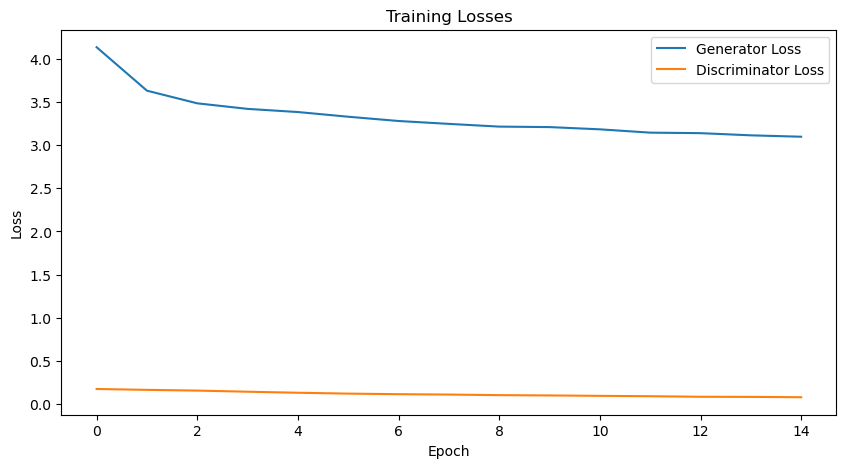

In [56]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()

In [57]:
# Cell 10: Test Set Evaluation
def evaluate_on_test_set():
    G_AB.eval()
    G_BA.eval()
    
    with torch.no_grad():
        # Get 10 test images
        test_images_A = []
        test_images_B = []
        
        for i, (real_A, real_B) in enumerate(test_loader):
            test_images_A.append(real_A[:2])
            test_images_B.append(real_B[:2])
            if len(test_images_A) >= 5:  # 5 batches of 2 = 10 images
                break
        
        test_images_A = torch.cat(test_images_A, 0).to(device)
        test_images_B = torch.cat(test_images_B, 0).to(device)
        
        # Generate translations
        fake_B = G_AB(test_images_A)  # Selfie to Anime
        fake_A = G_BA(test_images_B)  # Anime to Selfie
        
        # Display results
        fig, axes = plt.subplots(4, 10, figsize=(20, 8))
        
        for i in range(10):
            # Selfie to Anime
            axes[0, i].imshow(((test_images_A[i].cpu() + 1) / 2).permute(1, 2, 0))
            axes[0, i].set_title('Original Selfie')
            axes[0, i].axis('off')
            
            axes[1, i].imshow(((fake_B[i].cpu() + 1) / 2).permute(1, 2, 0))
            axes[1, i].set_title('Generated Anime')
            axes[1, i].axis('off')
            
            # Anime to Selfie
            axes[2, i].imshow(((test_images_B[i].cpu() + 1) / 2).permute(1, 2, 0))
            axes[2, i].set_title('Original Anime')
            axes[2, i].axis('off')
            
            axes[3, i].imshow(((fake_A[i].cpu() + 1) / 2).permute(1, 2, 0))
            axes[3, i].set_title('Generated Selfie')
            axes[3, i].axis('off')
        
        plt.tight_layout()
        plt.show()

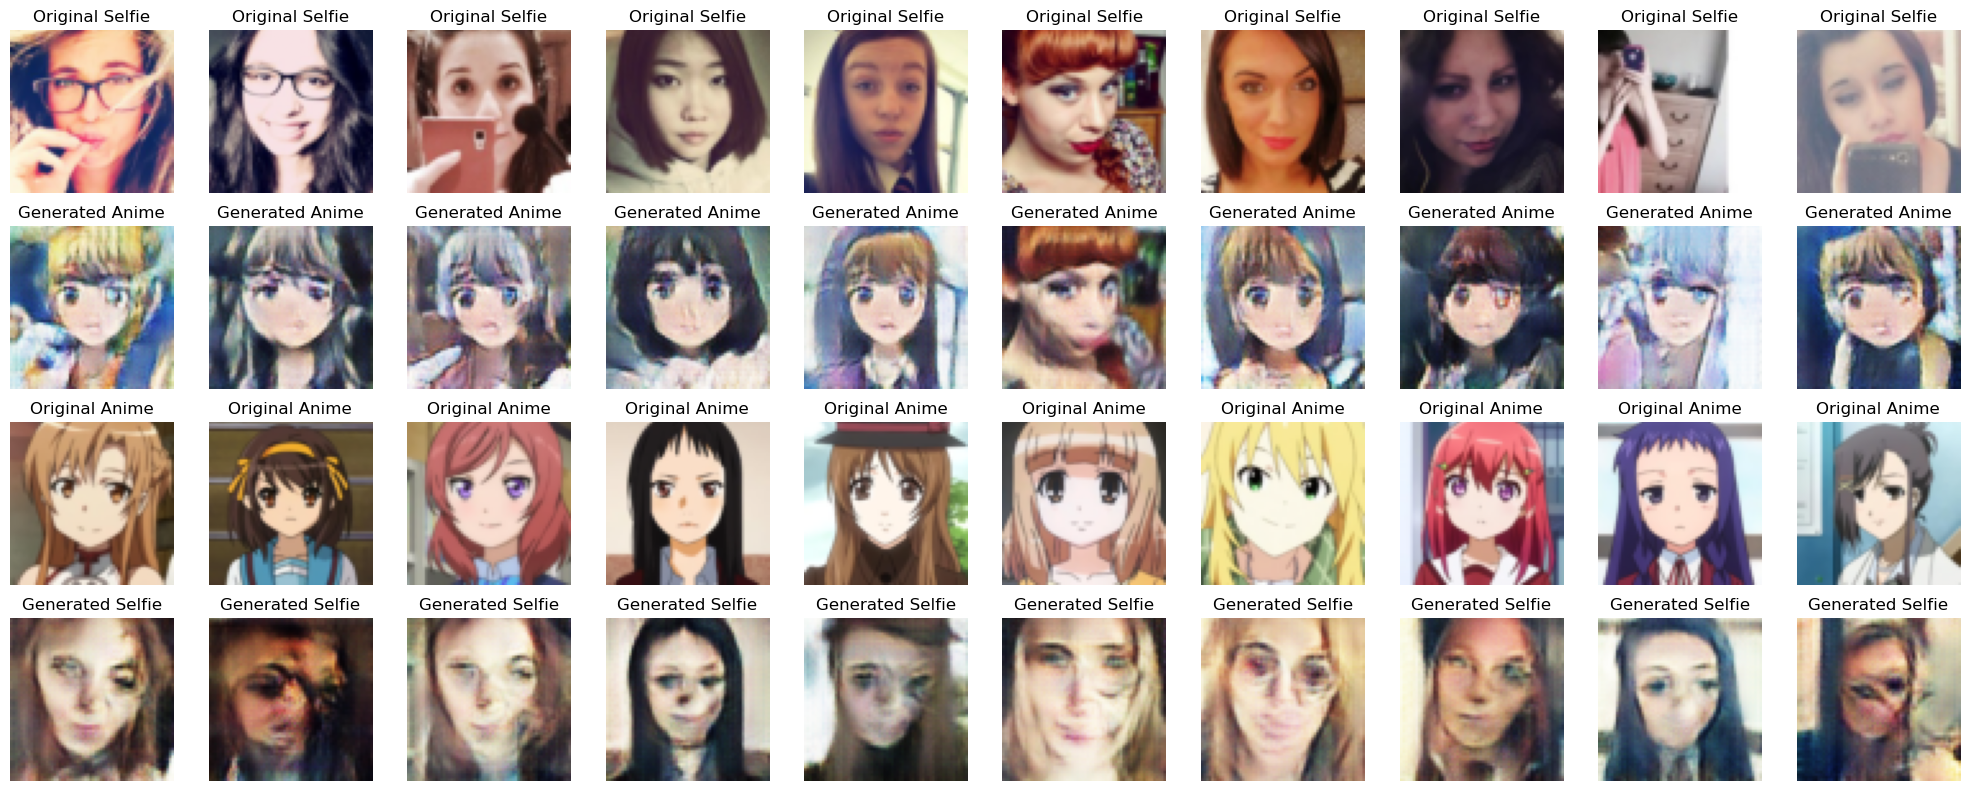

In [58]:
# Run evaluation
evaluate_on_test_set()

In [61]:
# Cell 11: Internet Images Evaluation
import requests
from io import BytesIO

def load_internet_image_from_url(url):
    transform_test = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Failed to download image from {url}")
        return None
    
    try:
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = transform_test(img).unsqueeze(0)
        return img
    except Exception as e:
        print(f"Error processing image from {url}: {e}")
        print(f"Content type: {response.headers.get('content-type', 'unknown')}")
        print(f"Content length: {len(response.content)}")
        return None

def evaluate_internet_images():
    G_AB.eval()
    G_BA.eval()
    
    # Image URLs
    selfie_urls = [
        'https://i.imgur.com/m7Em3S2.png',
        'https://i.imgur.com/2lzy9Un.png',
        'https://i.imgur.com/eg7lsZ2.png'
    ]
    
    anime_urls = [
        'https://i.imgur.com/2lCFEIY.png',
        'https://i.imgur.com/kYXGdqM.png',
        'https://i.imgur.com/G6tQMt9.png'
    ]
    
    with torch.no_grad():
        fig, axes = plt.subplots(2, 6, figsize=(15, 5))
        
        for i in range(3):
            # Load and process selfie
            selfie_img = load_internet_image_from_url(selfie_urls[i])
            if selfie_img is None:
                continue
            selfie_img = selfie_img.to(device)
            anime_generated = G_AB(selfie_img)
            
            # Load and process anime
            anime_img = load_internet_image_from_url(anime_urls[i])
            if anime_img is None:
                continue
            anime_img = anime_img.to(device)
            selfie_generated = G_BA(anime_img)
            
            # Display results
            axes[0, i*2].imshow(((selfie_img[0].cpu() + 1) / 2).permute(1, 2, 0))
            axes[0, i*2].set_title('Internet Selfie')
            axes[0, i*2].axis('off')
            
            axes[0, i*2+1].imshow(((anime_generated[0].cpu() + 1) / 2).permute(1, 2, 0))
            axes[0, i*2+1].set_title('Generated Anime')
            axes[0, i*2+1].axis('off')
            
            axes[1, i*2].imshow(((anime_img[0].cpu() + 1) / 2).permute(1, 2, 0))
            axes[1, i*2].set_title('Internet Anime')
            axes[1, i*2].axis('off')
            
            axes[1, i*2+1].imshow(((selfie_generated[0].cpu() + 1) / 2).permute(1, 2, 0))
            axes[1, i*2+1].set_title('Generated Selfie')
            axes[1, i*2+1].axis('off')
        
        plt.tight_layout()
        plt.show()



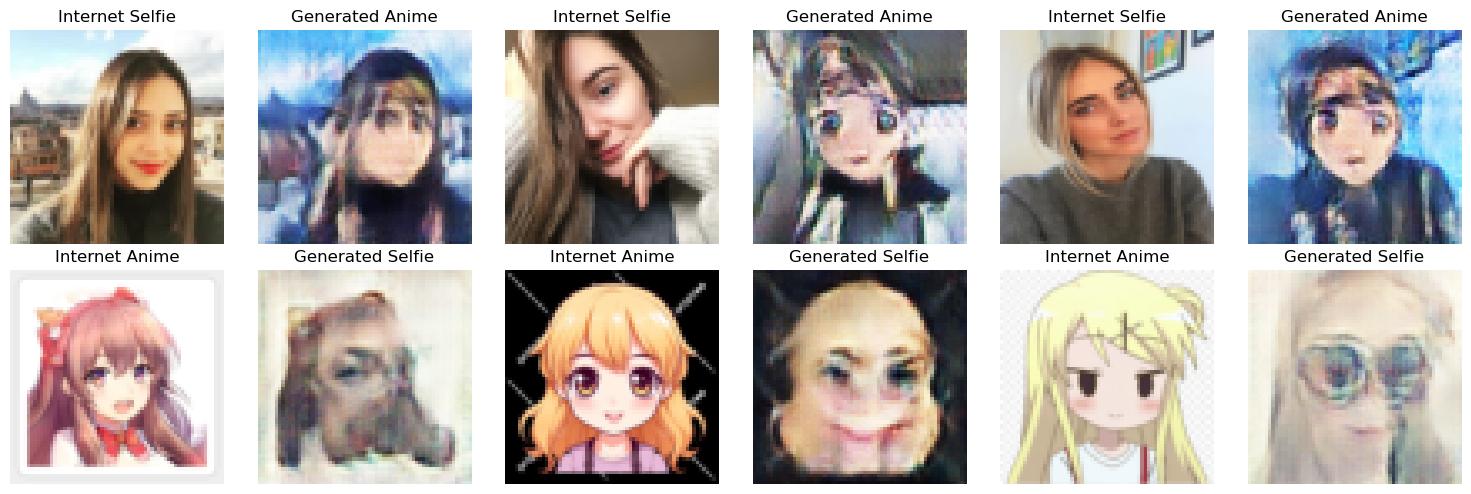

In [62]:
# Run evaluation on internet images
evaluate_internet_images()

In [63]:
# Save trained models
torch.save(G_AB.state_dict(), 'generator_AB.pth')
torch.save(G_BA.state_dict(), 'generator_BA.pth')
torch.save(D_A.state_dict(), 'discriminator_A.pth')
torch.save(D_B.state_dict(), 'discriminator_B.pth')

print("Training completed and models saved!")

Training completed and models saved!
